In [1]:
import tensorflow as tf
import tensorflowjs as tfjs

## Data Pipeline

Data pipeline using AffectNet and TensorFlow data operations.



In [2]:
train_dir = "/Users/joshua/Desktop/quality_dataset/train"
val_dir = "/Users/joshua/Desktop/quality_dataset/val"

# Execute augmentation lazily.
@tf.function
def data_augmentation(images, labels):
  images = tf.image.random_flip_left_right(images)
  images = tf.image.random_saturation(images, 0.6, 1.5)
  images = tf.image.random_brightness(images, max_delta=0.4)
  return images, labels

# Create training generator.
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, label_mode = "categorical", image_size=(96, 96), batch_size=32, seed = 2024)
LABEL_MAP = dict(enumerate(train_ds.class_names))
train_ds = train_ds.map(data_augmentation)

# Create validation generator.
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, label_mode = "categorical", image_size=(96, 96), batch_size=32, validation_split=0.5, subset="training", seed = 2024)
test_ds = tf.keras.utils.image_dataset_from_directory(val_dir, label_mode = "categorical", image_size=(96, 96), batch_size=32, validation_split=0.5, subset="validation", seed = 2024)

# Prefetch batches while running generator.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 10677 files belonging to 3 classes.
Found 2669 files belonging to 3 classes.
Using 1335 files for training.
Found 2669 files belonging to 3 classes.
Using 1334 files for validation.


## Modeling

Transfer learning with EfficientNetV2.

In [3]:
def build_feature_cnn(input_shape=(96,96,3), num_classes=3):
    
    # Define feature extraction layer.
    feature_extractor = tf.keras.applications.EfficientNetV2S(input_shape = input_shape, include_top = False)
    feature_extractor.trainable = False

    # Assemble model with new classification head.
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = feature_extractor(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1280, activation="tanh")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    for _ in range(5):
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)

    return model


In [4]:
model = build_feature_cnn()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate = 0.02), loss='categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_ds, validation_data = val_ds, epochs = 40, callbacks = [early_stopping])

Epoch 1/40
334/334 [==============================] - 61s 158ms/step - loss: 1.2107 - accuracy: 0.4990 - val_loss: 0.9010 - val_accuracy: 0.6187
Epoch 2/40
334/334 [==============================] - 46s 137ms/step - loss: 0.9992 - accuracy: 0.5462 - val_loss: 0.8601 - val_accuracy: 0.6097
Epoch 3/40
334/334 [==============================] - 55s 165ms/step - loss: 0.9634 - accuracy: 0.5677 - val_loss: 0.8028 - val_accuracy: 0.6404
Epoch 4/40
334/334 [==============================] - 53s 159ms/step - loss: 0.9348 - accuracy: 0.5862 - val_loss: 0.8285 - val_accuracy: 0.5700
Epoch 5/40
334/334 [==============================] - 56s 168ms/step - loss: 0.9357 - accuracy: 0.5971 - val_loss: 0.8559 - val_accuracy: 0.5715
Epoch 6/40
334/334 [==============================] - 56s 167ms/step - loss: 0.9372 - accuracy: 0.5975 - val_loss: 0.7815 - val_accuracy: 0.6352
Epoch 7/40
334/334 [==============================] - 57s 169ms/step - loss: 0.9182 - accuracy: 0.6147 - val_loss: 0.7399 - val_ac

In [6]:
tfjs.converters.save_keras_model(model, "emotional/public/model")

## Plotting

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [6]:
%%capture
# Get all predictions with their known labels in the test_ds.
predictions = []
labels =  []
for x, y in test_ds:
  predictions.extend(model.predict(x))
  labels.extend(y.numpy())

predictions = np.asarray(predictions)
labels = np.asarray(labels)
max_predictions = np.argmax(predictions, axis = -1)
max_labels = np.argmax(labels, axis = -1)

1/1 [==============================] - 5s 5s/step


In [7]:
# Plot training history.

fig = px.line(history.history, height = 800, width = 1000)
fig.update_layout(
    template = "plotly_white", 
    yaxis_title='',
    xaxis_title='Epoch',
    yaxis_range=(0, 1),
    title = "Training Epochs",
    legend_title = "Monitored Value"
)

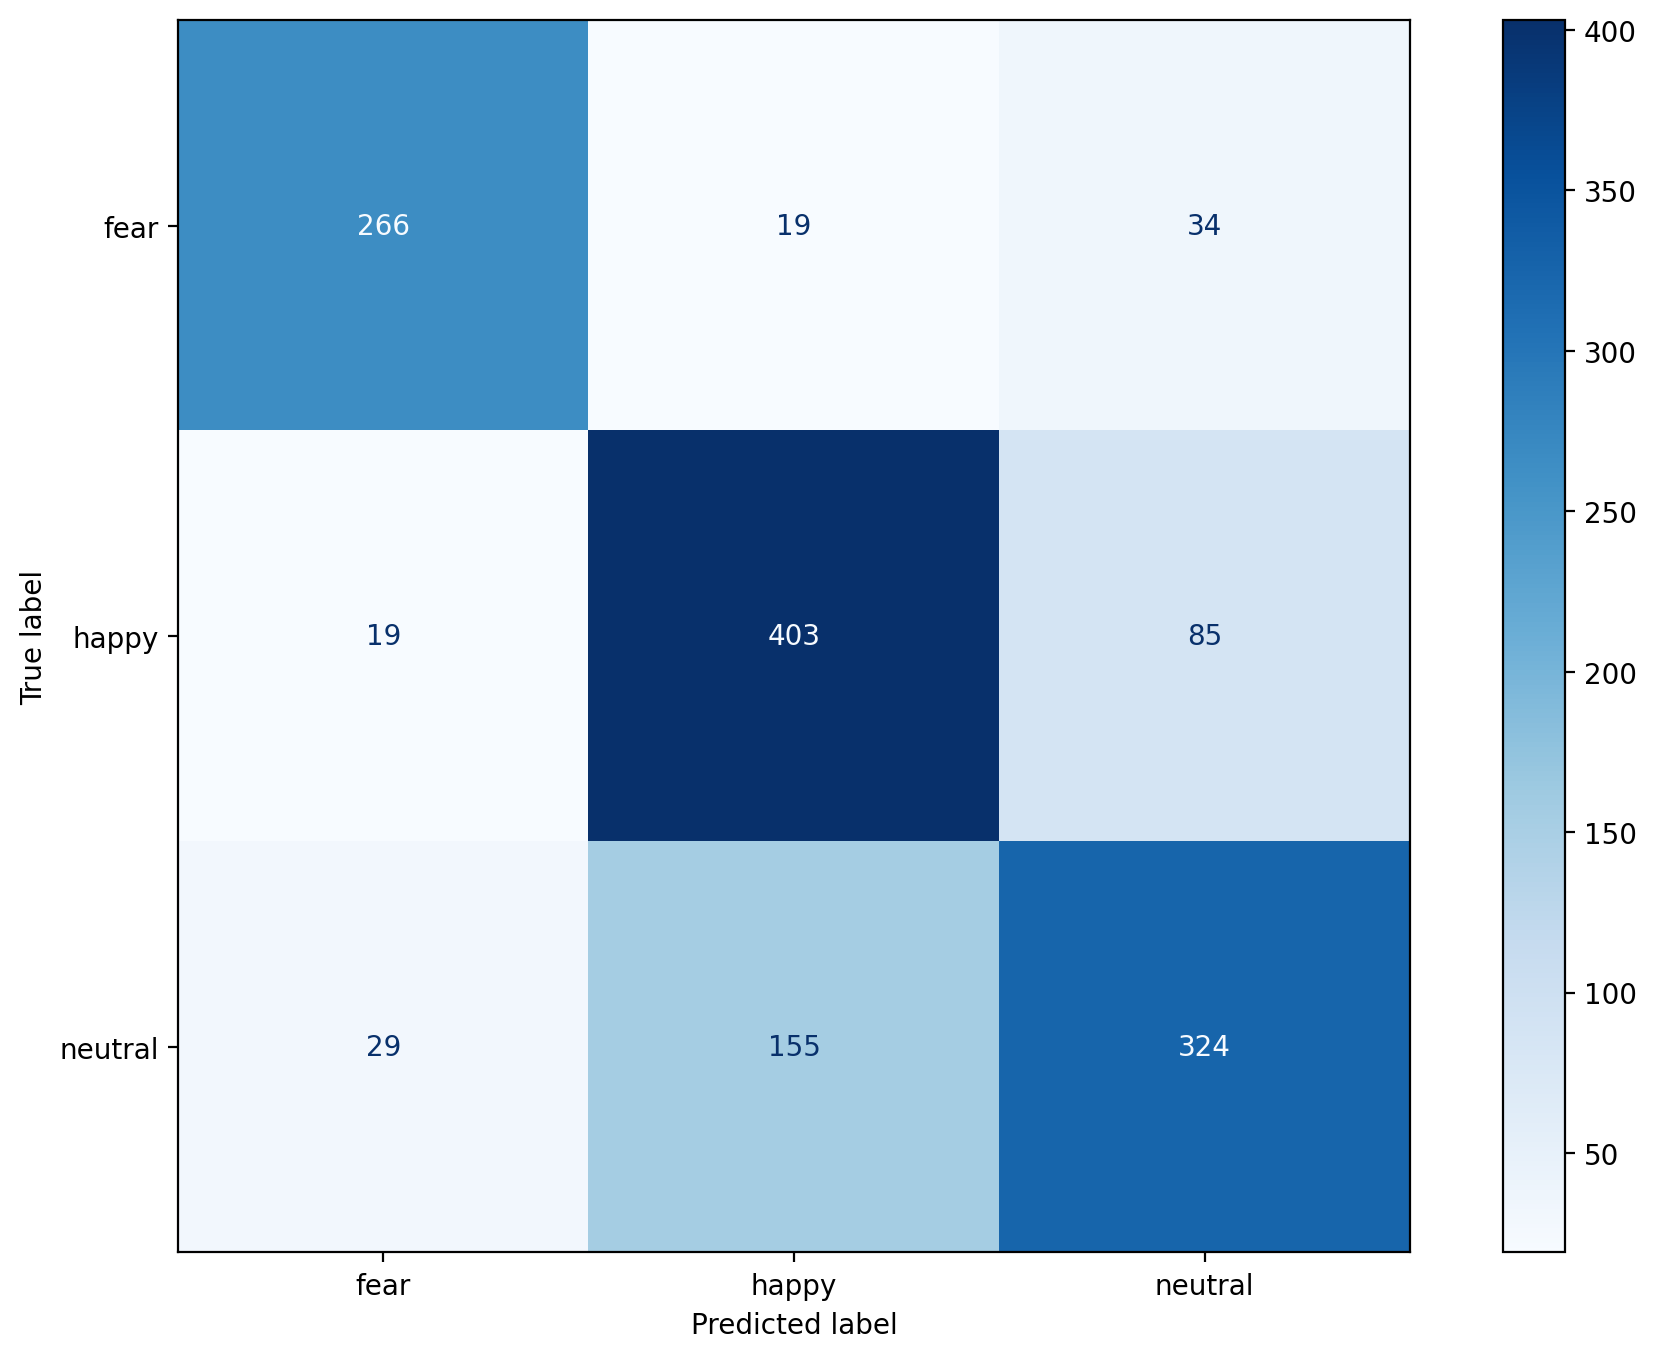

In [8]:
# Plot confusion matrix.
cm = confusion_matrix(max_labels, max_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(LABEL_MAP.values()))
disp.plot(cmap=plt.cm.Blues)
fig =plt.gcf()
fig.set_size_inches(12, 8)
fig.set_dpi(200)
plt.show()

In [9]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Create fig
fig = go.Figure()

# Plot all ROC curves in the same figure
class_names = ["fear", "happy", "neutral"]
for i in range(3):
    fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i])))

# Add random line.
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='random', line=dict(dash='dash')))

fig.update_layout(
    template = "plotly_white",
    xaxis_title='False Positive Rate',
                    yaxis_title='True Positive Rate',
                    title=f'Emotions ROC (n = {len(predictions)})', 
                    autosize=False,
                    width=900, 
                    height=800)

fig.show()